# WaveSolver - slider
M. Lamoureux May 31, 2016. Pacific Insitute for the Mathematical Sciences

Updated June 2017, to remove all reference to Bokeh, cuz it doesn't work now. (deprecated = broken)

(Bokeh = Brokehn)

This code does some numerical simulation of wave propagation in 1D, suitable for demoing in a class. 

This is a rewrite of some of my old Julia code, translated to run in Python. My belief is that Python is a more mature system and I will likely be more productive by sticking to Python instead of Julia. Let's see if this is true.

The code is based on formulas from the textbook Linear Partial Differential Equations for Scientists and Engineers, by Myint-U and Debnath. It's a good book -- you should buy it. Some extracts are also available online. 

In this Jupyter notebook, animation has been added, using GUI sliders to advance the waveform in time.


This was also written as a test of how far we can push Bokeh and the Jupyter Hub in making some calculations and graphics. There is some dangerous code at the bottom, that can bring down our Jupyter Hub, probably because it eats up too much memory. Interesting for debugging purposes, but you have been warned.





## Introduction to the 1D wave equation.

The basic idea is to represent the vibrations of a (horizonal) string under tension by a function $u(x,t)$ where $x$ is the horizontal displacement along the string, $t$ is the time parameter, and $y=u(x,t)$ indicates the (vertical) displacement of the string at point $x$ along the string, at time $t$ 

A typical wave would look something like
$$u(x,t) = \sin(x-ct)$$
which represents a sinusoidal wave moving to the right at velocity $c$.

From Newon's law of motion (mass times acceleration equals force), we can derive the wave equation for the string in the form 
$$ \rho \cdot u_{tt} = k \cdot u_{xx}$$
where $\rho$ is a mass density, $u_{tt}$ is an acceleration (the second derivative w.r.t. time), $k$ is the modulus of elasticity and $u_{xx}$ is a measure of curvature (the second derivative w.r.t. $x$), causing the bending force. 

Including boundary and initial conditions, while setting the parameter $c^2 = k/\rho$, we obtain the usual 1D wave equation on an interval as this:


$$u_{tt} = c^2 u_{xx} \mbox{ on interval } [x_0,x_1]$$
subject to boundary conditions
$$u(x_0,t) = u(x_1, t) = 0 \mbox{ for all $t$. }$$
and initial conditions
$$u(x,0) = u_0(x), \quad u_t(x,t) = u_1(x) \mbox{ on interval } [x_0,x_1].$$


Let's write some PDE solvers for this 1D wave equation.

Start with some simple solvers, then get more complex. 

The function to solve the PDE needs to know $c^2, u_0, u_1$, the sampling intervals $dx$ and $dt$, and the number of time steps to execute. Everything else can be inferred from those inputs. The output should be a 2D array, indexed in x and t steps. 

Maybe we could actually output the solution $u(x,t)$ as well as the vector of indices for $x$ and $t$.

## Software tools
We import some tools for numerical work (NumPy) and plotting (Matplotlib), using Matplotlib because Boken seems to be broken. At least, it broke my code with deprecations.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *


We also include some code from SciPy for numerical calculations

In [2]:
from scipy.linalg import solve_toeplitz  # a matrix equation solver
from scipy.integrate import cumtrapz # a numerical integrator, using trapezoid rule


And we include some code to create the graphical user interface -- namely, sliders. You can read about them here:
http://bokeh.pydata.org/en/0.10.0/_images/notebook_interactors.png

In [3]:
from ipywidgets import interact

## Explicit method of solution in finite differences

The finite difference method is probably the most common numerical method for solving PDEs. The derivatives are approximated by Newton difference ratios, and you step through in time to progress the solution from $t=0$ to some ending time.

The following defines a function that solves the wave equation, using an explicit finite difference method. We follow the notes in the referenced book by Myint-U and Debnath. 

The differencing in spatial variable $x$ is done by a convolution, as this will be fast. 

We print out the value of the CFL constant as a sanity check. The method is stable and convergent provided the CFL value is less than one. (This means $dt$ needs to be small enough.) See the book for details. 

The input parameters are velocity squared $c2$, spatial step size $dx$, temporal step size $dt$, number of time steps $t$_$len$, initial position $u0$ and initial velocity $u1$. $u0$ and $u1$ are arrays of some length $N$, which the code will use to deduce everything it needs to know.

I tend to think of these as dimensionless variables, but you can use real physical values if you like, so long as you are consistent. For instance $dx$ in meters, $dt$ in seconds, and $c2$ in (meters/second) squared. 

In [4]:
# Based on Section 14.4 in Myint-U and Debnath's book
def w_solve1(c2,dx,dt,t_len,u0,u1):
    x_len = np.size(u0)  # the length of u0 implicitly defines the num of points in x direction
    u = np.zeros((x_len,t_len),order='F') # output array initialized to zero 
    e2 = c2*dt*dt/(dx*dx)  # Courant parameter squared (test for convergence!)
    print("CFL value is ",np.sqrt(e2))
    kern = np.array([e2, 2*(1-e2), e2]) # the convolution kernel we need for laplacian solver
    u[:,0] = u0            # t=0 initial condition
    u[:,1] = np.convolve(u0,kern/2)[1:x_len+1] + dt*u1 # t=0 derivative condition, eqn 14.4.6
    for j in range(2,t_len):
        u[:,j] = np.convolve(u[:,j-1],kern)[1:x_len+1] - u[:,j-2] # eqn 14.4.3
    # let's produce the x and t vectors, in case we need them
    x = np.linspace(0,dx*x_len,x_len,endpoint=False)
    t = np.linspace(0,dt*t_len,t_len,endpoint=False)
    return u,x,t

Let's try a real wave equation solution. 
    
We start with a simple triangle waveform.

In [5]:
x_len = 1000
t_len = 1000
dx = 1./x_len
dt = 1./t_len
x = np.linspace(0,1,x_len)
t = np.linspace(0,1,t_len)
triangle = np.maximum(0.,.1-np.absolute(x-.4))

Now we call up our wave equation solver, using the parameters above

In [6]:
# Here we solve the wave equation, with initial position $u(x,0)$ set to the triangle waveform
(u,x,t)=w_solve1(.5,dx,dt,t_len,triangle,0*triangle)

CFL value is  0.707106781187


We can plot the inital waveform, just to see what it looks like. 

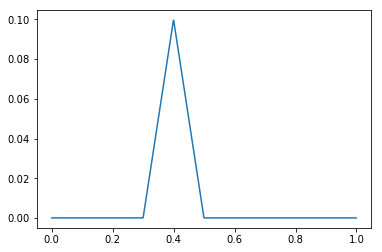

In [7]:
plot(x,u[:,0])

In [8]:
def update(k=0):
    plot(x,u[:,k])
    show()

And the next cell sets up a slider which controls the above graphs (it moves time along)

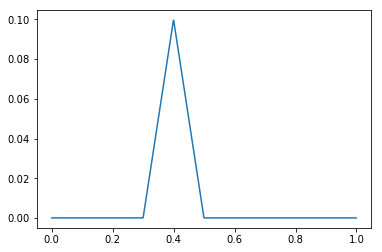

In [9]:
# This runs an animation, controlled by a slider which advances time
interact(update,k=(0,t_len-1))

### Derivative initial condition test

In [10]:
# We try again, but this time with the $u_t$ initial condition equal to the triangle impulse
(u,x,t)=w_solve1(.5,dx,dt,3*t_len,0*triangle,1*triangle)

CFL value is  0.707106781187


We can use the same update function, since nothing has changed. 

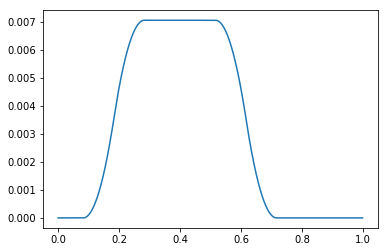

In [11]:
interact(update,k=(0,3*t_len-1))

## Implicit method

Here we try an implicit method for solving the wave equation. Again from Myint-U and Debnath's book, in Section 14.5, part (B) on Hyperbolic equations. 

We need to use scipy libraries as we have to solve a system of linear equation. In fact the system is tridiagonal and Toepliz, so this should be fast. I see how to use Toepliz in scipy, but I don't know how to tell it that the system is only tridiagonal. It should be possible to speed this up. 

In [12]:
# Based on Section 14.5 (B) in Myint-U and Debnath's book
def w_solve2(c2,dx,dt,t_len,u0,u1):
    x_len = np.size(u0)  # the length of u0 implicitly defines the num of points in x direction
    u = np.zeros((x_len,t_len),order='F') # output array initialized to zero 
    e2 = c2*dt*dt/(dx*dx)  # Courant parameter squared (test for convergence!)
    print("CFL value is ",np.sqrt(e2))
    kern = np.array([e2, 2*(1-e2), e2]) # the convolution kernel we need for laplacian solver
    u[:,0] = u0            # t=0 initial condition
    u[:,1] = np.convolve(u0,kern/2)[1:x_len+1] + dt*u1 # t=0 derivative condition, eqn 14.4.6
    # Note the above is a cheat, we are using the explicit method to find u[:,1], Should do this implicitly
    kern2 = np.array([e2, -2*(1+e2), e2]) # the convolution kernel we need for implicit solver. It is different.
    toepk = np.zeros(x_len)  # this will hold the entries for the tridiagonal Toeplitz matrix
    toepk[0] = 2*(1+e2);
    toepk[1] = -e2
    for j in range(2,t_len):
        rhs = np.convolve(u[:,j-2],kern2)[1:x_len+1] + 4*u[:,j-1] # eqn 14.5.17
        u[:,j] = solve_toeplitz(toepk, rhs) # here is a linear system solver (hence an implicit method)
    # let's produce the x and t vectors, in case we need them
    x = np.linspace(0,dx*x_len,x_len,endpoint=False)
    t = np.linspace(0,dt*t_len,t_len,endpoint=False)
    return u,x,t

In [13]:
(u,x,t)=w_solve2(.5,dx,dt,t_len,1*triangle,0*triangle)

CFL value is  0.707106781187


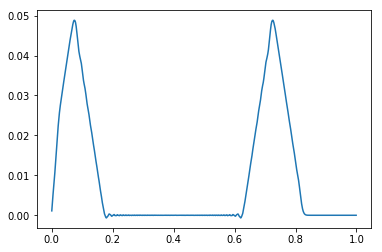

In [14]:
interact(update,k=(0,3*t_len-1))

### Derivative initial condition

In [15]:
(u,x,t)=w_solve2(.5,dx,dt,3*t_len,0*triangle,1*triangle)

CFL value is  0.707106781187


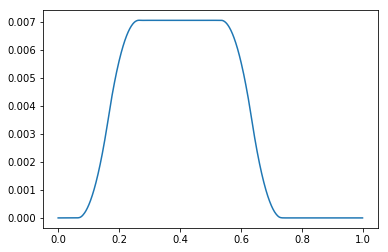

In [16]:
interact(update,k=(0,3*t_len-1))

## D'Alembert's solution

Since the velocity $c$ is constant in these examples, we can get the exact solution via D'Alembert. The general solution will be of the form 
$$u(x,t) = \phi(x+ct) + \psi(x-ct). $$
Initial conditions tell use that
$$u(x,0) = \phi(x) + \psi(x) = f(x), $$ and
$$u_t(x,0) = c\phi'(x) - c\psi'(x) = g(x). $$
With $G(x)$ the antiderivative of $g(x)$ with appropriate zero at zero, we get a 2x2 system
$$\phi(x) + \psi(x) = f(x), \\ c(\phi(x) - \psi(x)) = G(x),$$
which we solve as
$$\phi(x) = \frac{1}{2}\left( f(x) + \frac{1}{c} G(x) \right), \\
  \psi(x) = \frac{1}{2}\left( f(x) - \frac{1}{c} G(x) \right).$$

Now $f(x)$ is given as the argument $u0$ in the code. $G(x)$ can be computed using scipy. The arguments $x+ct$ and $x-ct$ must be converted to integer indices. They have to wrap around. And with the zero boundary condition, we need to wrap around with a negative reflection. 

There is the messy question as to whether we require $u(0,t)$ to actually equal zero, or do we require it to be zero one index "to the left" of x=0. Let's not think too much about that just yet.

In [17]:
# Based on D'Alembert's solution, as described above
def w_solve3(c2,dx,dt,t_len,u0,u1):
    x_len = np.size(u0)  # the length of u0 implicitly defines the num of points in x direction
    u = np.zeros((x_len,t_len),order='F') # output array initialized to zero 
    c = np.sqrt(c2)  # the actual velocity parameter is needed
    f = u0  # use notation from above notes
    G = cumtrapz(u1,dx=dx,initial=0) # the antiderivative, using cumulative trapezoidal rule
    f2 = np.append(f,-f[::-1]) # odd symmetry
    G2 = np.append(G,G[::-1]) # even symmetry
    phi2 = (f2 + G2/c)/2
    psi2 = (f2 - G2/c)/2
    x = np.linspace(0,dx*x_len,x_len,endpoint=False)
    t = np.linspace(0,dt*t_len,t_len,endpoint=False)
    # in the loop, we convert x+ct to index's into vectors phi2, psi2, modulo the vector length
    for j in range(t_len):
        ii1 = np.mod( np.round((x+c*t[j])/dx), 2*x_len)
        ii2 = np.mod( np.round((x-c*t[j])/dx), 2*x_len)
        u[:,j] = phi2[ii1.astype(int)] + psi2[ii2.astype(int)]
    return u,x,t

In [18]:
(u,x,t)=w_solve3(.5,dx,dt,t_len,1*triangle,0*triangle)

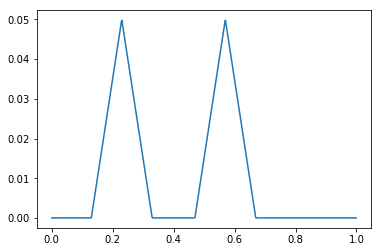

In [19]:
interact(update,k=(0,t_len-1))


### Derivative initial condition

In [20]:
(u,x,t)=w_solve3(.5,dx,dt,3*t_len,0*triangle,1*triangle)

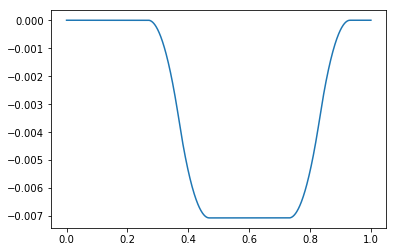

In [21]:
interact(update,k=(0,3*t_len-1))

# Comparing solutions

In principle, we want these different solution methods to be directly comparable.

So let's try this out, by computing the difference of two solution. 

Here we compare the explicit f.d. method with d'Alambert's method.


In [22]:
(u_exp,x,t)=w_solve1(.5,dx,dt,t_len,1*triangle,0*triangle)
(u_dal,x,t)=w_solve3(.5,dx,dt,t_len,1*triangle,0*triangle)

CFL value is  0.707106781187


In [23]:
def update2(k=0):
    plot(x,u_dal[:,k]-u_exp[:,k])
    show()    

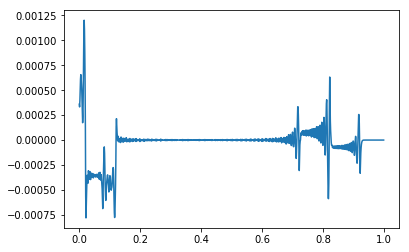

In [25]:
interact(update2,k=(0,t_len-1))

## A moving wavefront

Let's try an actual wave. We want something like
$$u(x,t) = \exp(-(x -x_a-ct)^2/w^2), $$
where $x_a$ is the center of the Gaussian at $t=0$, $w$ is the width of the Gaussian, $c$ is the velocity of the wave.

This gives
$$u_0(x) = \exp(-(x -x_a)^2/w^2) \\
  u_1(x) = \frac{2c(x-x_a)}{w^2}\exp(-(x -x_a)^2/w^2) = \frac{2c(x-x_a)}{w^2}u_0(x).$$


In [26]:
c = .707  # velocity
x_len = 1000
t_len = 1000
dx = 1./x_len
dt = 1./t_len
x = np.linspace(0,1,x_len)
t = np.linspace(0,1,t_len)
u0 = np.exp(-(x-.5)*(x-.5)/.01)
u1 = 2*c*u0*(x-.5)/.01

In [27]:
(u,x,t)=w_solve3(c*c,dx,dt,t_len,u0,u1)  # notice we input the velocity squared!

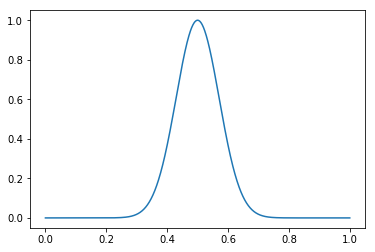

In [28]:
interact(update,k=(0,t_len-1))